In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from transformers import ViTForImageClassification, ViTMAEConfig, ViTConfig, ViTMAEModel, ViTImageProcessor, TrainingArguments, Trainer
from PIL import Image
import matplotlib.pyplot as plt
import requests
from datasets import load_dataset
import torch
import numpy as np
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device


/home/jiachenyuan/miniconda3/envs/cs444env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda:0'

In [4]:
model = ViTForImageClassification.from_pretrained('facebook/vit-mae-base', num_labels=10)
# Turn off the masking mechanism, we need full image for downstream application
# model.config.mask_ratio = 0.0
processor = ViTImageProcessor.from_pretrained('facebook/vit-mae-base')
# print(processor)
processor.do_rescale = False
processor

You are using a model of type vit_mae to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/vit-mae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": false,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [8]:
transform = transforms.Compose(
    [transforms.Resize(224),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ]
)

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                          shuffle=True, num_workers=4)

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# class ViTMAEImageClassification(nn.Module):
#     def __init__(self, mae_model, num_labels):
#         super().__init__()
#         self.mae_model = mae_model
#         # Add a classifier head: a linear layer for classification
#         self.classifier_head = nn.Linear(mae_model.config.hidden_size, num_labels)
        

#     def forward(self, pixel_values, **kwargs):
#         # Use the MAE model's forward method
#         outputs = self.mae_model(pixel_values, **kwargs)
        
#         # Assuming outputs.last_hidden_state[:, 0] gives the [CLS] token representation
#         cls_output = outputs.last_hidden_state[:, 0]

#         # Pass the [CLS] token representation through the classifier head
#         logits = self.classifier_head(cls_output)
        
#         return logits

# # Set number of labels
# num_labels = 10
# model = ViTMAEImageClassification(mae_model=model, num_labels=num_labels)



# Fix ViTMAE weights, only leave fc layer trainable
for param in model.parameters():
    param.requires_grad = False
for name, param in model.classifier.named_parameters():
    param.requires_grad = True

# Check if only the last layer is tunable
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)


model = model.to(device)

classifier.weight
classifier.bias


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.classifier.parameters(), lr=0.005)
num_epochs = 20
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.8)


In [6]:
def evaluate_model(loader):
    num_correct = 0
    total = 0
    eval_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(loader, 0), total=len(loader)):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = processor(inputs, return_tensors='pt')
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(**inputs)
            outputs = outputs.logits

            loss = criterion(outputs, labels)
            eval_loss += loss.item()
            prediction = outputs.argmax(dim=-1)

            total += prediction.size(0)
            num_correct += (prediction == labels).sum().item()


    # print('Finished eval')
    # print('correctness: ', (num_correct / total * 100).item(), '%')
    return eval_loss/len(loader), num_correct / total


In [7]:
train_losses = []
test_losses = []
test_acc = []

In [8]:
# Train
train_loss_count_freq = 100
test_loss_min = np.Inf
for epoch in range(num_epochs):  # loop over the dataset multiple times
    model.train()
    running_train_loss = 0.0
    train_loss_buffer = []
    for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = processor(inputs, return_tensors='pt')
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(**inputs)
        outputs = outputs.logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss_buffer.append(loss.item())
        if i % train_loss_count_freq == (train_loss_count_freq - 1):
            mean_train_loss = np.mean(train_loss_buffer)
            print(f'[{epoch + 1}, {i + 1:5d}] train loss: {mean_train_loss}')
            train_losses.append(mean_train_loss)
            train_loss_buffer.clear()

    # Evaluate on validation and test set
    model.eval()
    test_loss, correctness_test = evaluate_model(testloader)

    test_losses.append(test_loss)
    test_acc.append(correctness_test)
    # avg_train_loss = 0.0    
    print(f'[{epoch + 1}, {i + 1:5d}] train loss: {train_losses[-1]:.3f}, valid_loss: {test_loss:.3f}, acc: {correctness_test*100}%, lr={optimizer.param_groups[0]["lr"]}')

    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        test_loss_min,
        test_loss))
        
        torch.save(model.state_dict(), 'model_cifar.pt')
        test_loss_min = test_loss

    train_losses_t = np.array(train_losses)
    test_losses_t = np.array(test_losses)
    np.save('train_losses.npy', train_losses_t)
    np.save('test_losses.npy', test_losses_t)
    np.save('test_correctness.npy', test_acc)

    scheduler.step()

print('Finished Training')

  0%|          | 0/3125 [00:00<?, ?it/s]

/home/jiachenyuan/miniconda3/envs/cs444env/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
  3%|▎         | 102/3125 [00:09<04:51, 10.39it/s]

[1,   100] train loss: 1.5330674546957015


  6%|▋         | 202/3125 [00:19<04:44, 10.29it/s]

[1,   200] train loss: 0.9568516865372658


 10%|▉         | 302/3125 [00:29<04:30, 10.44it/s]

[1,   300] train loss: 0.8629426676034927


 13%|█▎        | 402/3125 [00:38<04:21, 10.43it/s]

[1,   400] train loss: 0.7438341042399407


 16%|█▌        | 502/3125 [00:48<04:11, 10.42it/s]

[1,   500] train loss: 0.7051292157173157


 19%|█▉        | 602/3125 [00:57<04:03, 10.36it/s]

[1,   600] train loss: 0.6709593406319618


 22%|██▏       | 702/3125 [01:07<03:54, 10.32it/s]

[1,   700] train loss: 0.657740608304739


 26%|██▌       | 802/3125 [01:17<03:40, 10.53it/s]

[1,   800] train loss: 0.6191210490465164


 29%|██▉       | 902/3125 [01:26<03:26, 10.74it/s]

[1,   900] train loss: 0.5907714635133743


 32%|███▏      | 1000/3125 [01:36<03:17, 10.74it/s]

[1,  1000] train loss: 0.5742764192819595


 35%|███▌      | 1102/3125 [01:46<03:16, 10.28it/s]

[1,  1100] train loss: 0.609426527172327


 38%|███▊      | 1202/3125 [01:55<03:00, 10.66it/s]

[1,  1200] train loss: 0.6066497772932052


 42%|████▏     | 1301/3125 [02:06<03:02,  9.97it/s]

[1,  1300] train loss: 0.5373780885338784


 45%|████▍     | 1402/3125 [02:16<02:47, 10.26it/s]

[1,  1400] train loss: 0.5688216099143029


 48%|████▊     | 1501/3125 [02:26<02:38, 10.24it/s]

[1,  1500] train loss: 0.5400371851027012


 51%|█████▏    | 1602/3125 [02:36<02:34,  9.83it/s]

[1,  1600] train loss: 0.5410164769738912


 54%|█████▍    | 1702/3125 [02:46<02:18, 10.31it/s]

[1,  1700] train loss: 0.5232075692713261


 58%|█████▊    | 1801/3125 [02:56<02:14,  9.88it/s]

[1,  1800] train loss: 0.5255146442353725


 61%|██████    | 1901/3125 [03:06<02:02,  9.96it/s]

[1,  1900] train loss: 0.48358690954744815


 64%|██████▍   | 2001/3125 [03:16<01:53,  9.94it/s]

[1,  2000] train loss: 0.5391670491546392


 67%|██████▋   | 2101/3125 [03:26<01:40, 10.17it/s]

[1,  2100] train loss: 0.5032352420687676


 70%|███████   | 2202/3125 [03:36<01:30, 10.19it/s]

[1,  2200] train loss: 0.513979812413454


 74%|███████▎  | 2302/3125 [03:46<01:21, 10.09it/s]

[1,  2300] train loss: 0.4371426837146282


 77%|███████▋  | 2401/3125 [03:56<01:15,  9.58it/s]

[1,  2400] train loss: 0.5054015126824379


 80%|████████  | 2501/3125 [04:06<01:02,  9.99it/s]

[1,  2500] train loss: 0.5118927725404501


 83%|████████▎ | 2601/3125 [04:16<00:51, 10.15it/s]

[1,  2600] train loss: 0.5126257563382387


 86%|████████▋ | 2701/3125 [04:27<00:42, 10.01it/s]

[1,  2700] train loss: 0.5003490956127643


 90%|████████▉ | 2802/3125 [04:37<00:31, 10.16it/s]

[1,  2800] train loss: 0.4766164430975914


 93%|█████████▎| 2901/3125 [04:47<00:24,  9.03it/s]

[1,  2900] train loss: 0.4821930790692568


 96%|█████████▌| 3001/3125 [04:57<00:14,  8.60it/s]

[1,  3000] train loss: 0.4708139762282372


 99%|█████████▉| 3101/3125 [05:07<00:02, 10.18it/s]

[1,  3100] train loss: 0.463293940089643


100%|██████████| 625/625 [01:04<00:00,  9.65it/s]


[1,  3125] train loss: 0.463, valid_loss: 0.488, acc: 83.04%, lr=0.005
Validation loss decreased (inf --> 0.488220).  Saving model ...


  3%|▎         | 101/3125 [00:10<05:09,  9.76it/s]

[2,   100] train loss: 0.43595480769872663


  6%|▋         | 200/3125 [00:20<04:51, 10.04it/s]

[2,   200] train loss: 0.4799364766478538


 10%|▉         | 301/3125 [00:31<04:40, 10.08it/s]

[2,   300] train loss: 0.41777520343661306


 13%|█▎        | 401/3125 [00:41<04:40,  9.72it/s]

[2,   400] train loss: 0.46308567494153974


 16%|█▌        | 500/3125 [00:52<04:24,  9.93it/s]

[2,   500] train loss: 0.4459448122233152


 19%|█▉        | 601/3125 [01:03<04:43,  8.90it/s]

[2,   600] train loss: 0.48072519183158874


 22%|██▏       | 701/3125 [01:13<04:01, 10.04it/s]

[2,   700] train loss: 0.4514330377429724


 26%|██▌       | 801/3125 [01:24<04:01,  9.64it/s]

[2,   800] train loss: 0.44961686998605727


 29%|██▉       | 901/3125 [01:34<03:45,  9.85it/s]

[2,   900] train loss: 0.476232291162014


 32%|███▏      | 1002/3125 [01:45<04:32,  7.79it/s]

[2,  1000] train loss: 0.4503073117882013


 35%|███▌      | 1101/3125 [01:57<03:44,  9.03it/s]

[2,  1100] train loss: 0.46110774718225


 38%|███▊      | 1201/3125 [02:08<03:15,  9.85it/s]

[2,  1200] train loss: 0.45259011678397654


 42%|████▏     | 1301/3125 [02:19<03:05,  9.84it/s]

[2,  1300] train loss: 0.4459427770972252


 45%|████▍     | 1401/3125 [02:30<03:07,  9.20it/s]

[2,  1400] train loss: 0.4214225346595049


 48%|████▊     | 1501/3125 [02:40<02:48,  9.65it/s]

[2,  1500] train loss: 0.4285168127715588


 51%|█████     | 1601/3125 [02:50<02:37,  9.65it/s]

[2,  1600] train loss: 0.4237800767272711


 54%|█████▍    | 1701/3125 [03:01<02:27,  9.66it/s]

[2,  1700] train loss: 0.42873769760131836


 58%|█████▊    | 1801/3125 [03:12<02:43,  8.12it/s]

[2,  1800] train loss: 0.46744688257575034


 61%|██████    | 1901/3125 [03:23<02:05,  9.74it/s]

[2,  1900] train loss: 0.4310473920404911


 64%|██████▍   | 2002/3125 [03:33<01:51, 10.06it/s]

[2,  2000] train loss: 0.41515676893293857


 67%|██████▋   | 2101/3125 [03:44<01:46,  9.61it/s]

[2,  2100] train loss: 0.43971756104379894


 70%|███████   | 2201/3125 [03:55<01:40,  9.19it/s]

[2,  2200] train loss: 0.425403982847929


 74%|███████▎  | 2301/3125 [04:06<01:27,  9.45it/s]

[2,  2300] train loss: 0.4267545171827078


 77%|███████▋  | 2402/3125 [04:17<01:13,  9.83it/s]

[2,  2400] train loss: 0.4485700114816427


 80%|████████  | 2501/3125 [04:28<01:10,  8.91it/s]

[2,  2500] train loss: 0.42645785681903364


 83%|████████▎ | 2601/3125 [04:39<00:52, 10.01it/s]

[2,  2600] train loss: 0.43375304102897644


 86%|████████▋ | 2701/3125 [04:50<00:44,  9.58it/s]

[2,  2700] train loss: 0.43535820610821246


 90%|████████▉ | 2801/3125 [05:01<00:34,  9.46it/s]

[2,  2800] train loss: 0.4169123210012913


 93%|█████████▎| 2901/3125 [05:13<00:23,  9.49it/s]

[2,  2900] train loss: 0.41932080417871476


 96%|█████████▌| 3001/3125 [05:25<00:12,  9.78it/s]

[2,  3000] train loss: 0.4250220093131065


 99%|█████████▉| 3102/3125 [05:36<00:02,  7.74it/s]

[2,  3100] train loss: 0.4311721751838922


100%|██████████| 625/625 [01:08<00:00,  9.07it/s]

[2,  3125] train loss: 0.431, valid_loss: 0.505, acc: 81.56%, lr=0.005



  3%|▎         | 102/3125 [00:11<06:11,  8.14it/s]

[3,   100] train loss: 0.4139445122331381


  6%|▋         | 202/3125 [00:22<06:29,  7.50it/s]

[3,   200] train loss: 0.42925396919250486


 10%|▉         | 301/3125 [00:34<04:52,  9.67it/s]

[3,   300] train loss: 0.40741475354880097


 13%|█▎        | 401/3125 [00:45<04:41,  9.69it/s]

[3,   400] train loss: 0.4198000102490187


 16%|█▌        | 501/3125 [00:57<04:24,  9.93it/s]

[3,   500] train loss: 0.4057771959900856


 19%|█▉        | 600/3125 [01:08<04:45,  8.86it/s]

[3,   600] train loss: 0.3757242101430893


 22%|██▏       | 701/3125 [01:21<05:06,  7.91it/s]

[3,   700] train loss: 0.37473794016987083


 26%|██▌       | 801/3125 [01:32<04:24,  8.80it/s]

[3,   800] train loss: 0.4299025890976191


 29%|██▉       | 901/3125 [01:44<03:43,  9.97it/s]

[3,   900] train loss: 0.3970106915384531


 32%|███▏      | 1001/3125 [01:54<03:39,  9.68it/s]

[3,  1000] train loss: 0.42055200826376676


 35%|███▌      | 1101/3125 [02:05<03:28,  9.68it/s]

[3,  1100] train loss: 0.44222921758890155


 38%|███▊      | 1201/3125 [02:17<03:18,  9.70it/s]

[3,  1200] train loss: 0.444770113825798


 42%|████▏     | 1301/3125 [02:29<03:22,  9.01it/s]

[3,  1300] train loss: 0.3720986707508564


 45%|████▍     | 1401/3125 [02:41<03:05,  9.29it/s]

[3,  1400] train loss: 0.39065596632659433


 48%|████▊     | 1501/3125 [02:52<03:05,  8.75it/s]

[3,  1500] train loss: 0.3972083289176226


 51%|█████     | 1601/3125 [03:04<02:40,  9.49it/s]

[3,  1600] train loss: 0.38361531220376494


 54%|█████▍    | 1701/3125 [03:15<02:45,  8.59it/s]

[3,  1700] train loss: 0.4129149372130632


 58%|█████▊    | 1801/3125 [03:28<02:13,  9.92it/s]

[3,  1800] train loss: 0.3917482428252697


 61%|██████    | 1900/3125 [03:39<02:09,  9.46it/s]

[3,  1900] train loss: 0.43063460640609263


 64%|██████▍   | 2001/3125 [03:51<01:56,  9.66it/s]

[3,  2000] train loss: 0.42322324216365814


 67%|██████▋   | 2101/3125 [04:03<01:46,  9.59it/s]

[3,  2100] train loss: 0.433526244238019


 70%|███████   | 2201/3125 [04:15<01:55,  8.00it/s]

[3,  2200] train loss: 0.4299012404680252


 74%|███████▎  | 2301/3125 [04:27<01:31,  9.04it/s]

[3,  2300] train loss: 0.374134818315506


 77%|███████▋  | 2401/3125 [04:38<01:18,  9.23it/s]

[3,  2400] train loss: 0.4297416902333498


 80%|████████  | 2501/3125 [04:49<01:04,  9.69it/s]

[3,  2500] train loss: 0.41237178202718494


 83%|████████▎ | 2601/3125 [05:01<01:03,  8.25it/s]

[3,  2600] train loss: 0.385353581123054


 86%|████████▋ | 2701/3125 [05:13<00:44,  9.60it/s]

[3,  2700] train loss: 0.419517814218998


 90%|████████▉ | 2802/3125 [05:25<00:38,  8.35it/s]

[3,  2800] train loss: 0.4136323267966509


 93%|█████████▎| 2901/3125 [05:37<00:24,  9.28it/s]

[3,  2900] train loss: 0.3874794729053974


 96%|█████████▌| 3001/3125 [05:49<00:15,  8.10it/s]

[3,  3000] train loss: 0.378529814556241


 99%|█████████▉| 3101/3125 [06:02<00:02,  9.26it/s]

[3,  3100] train loss: 0.40233831986784935


100%|██████████| 625/625 [01:13<00:00,  8.45it/s]


[3,  3125] train loss: 0.402, valid_loss: 0.406, acc: 85.72999999999999%, lr=0.005
Validation loss decreased (0.488220 --> 0.406005).  Saving model ...


  3%|▎         | 101/3125 [00:09<05:04,  9.94it/s]

[4,   100] train loss: 0.38043193977326156


  6%|▋         | 202/3125 [00:19<04:30, 10.81it/s]

[4,   200] train loss: 0.4071021130681038


 10%|▉         | 301/3125 [00:29<04:35, 10.24it/s]

[4,   300] train loss: 0.40612641915678976


 13%|█▎        | 401/3125 [00:39<04:11, 10.83it/s]

[4,   400] train loss: 0.39779394164681436


 16%|█▌        | 501/3125 [00:49<04:01, 10.84it/s]

[4,   500] train loss: 0.4096665100753307


 19%|█▉        | 601/3125 [00:59<03:53, 10.83it/s]

[4,   600] train loss: 0.4130686187744141


 22%|██▏       | 701/3125 [01:09<03:49, 10.58it/s]

[4,   700] train loss: 0.39977108836174013


 26%|██▌       | 801/3125 [01:19<03:46, 10.27it/s]

[4,   800] train loss: 0.39328601699322463


 29%|██▉       | 901/3125 [01:29<03:41, 10.05it/s]

[4,   900] train loss: 0.37727325208485124


 32%|███▏      | 1002/3125 [01:39<03:28, 10.16it/s]

[4,  1000] train loss: 0.41193473532795905


 35%|███▌      | 1099/3125 [01:49<03:20, 10.12it/s]

[4,  1100] train loss: 0.3826964981108904


 38%|███▊      | 1201/3125 [01:59<03:27,  9.27it/s]

[4,  1200] train loss: 0.40531937032938004


 42%|████▏     | 1301/3125 [02:10<03:36,  8.41it/s]

[4,  1300] train loss: 0.413101823925972


 45%|████▍     | 1401/3125 [02:19<02:50, 10.10it/s]

[4,  1400] train loss: 0.3894101397693157


 48%|████▊     | 1501/3125 [02:29<02:36, 10.35it/s]

[4,  1500] train loss: 0.3788541703298688


 51%|█████     | 1601/3125 [02:41<02:48,  9.07it/s]

[4,  1600] train loss: 0.38380853153765204


 54%|█████▍    | 1701/3125 [02:53<02:57,  8.00it/s]

[4,  1700] train loss: 0.3899834823980928


 58%|█████▊    | 1801/3125 [03:05<03:08,  7.03it/s]

[4,  1800] train loss: 0.38834100499749186


 61%|██████    | 1901/3125 [03:17<02:40,  7.65it/s]

[4,  1900] train loss: 0.3789684381335974


 64%|██████▍   | 2002/3125 [03:29<02:32,  7.36it/s]

[4,  2000] train loss: 0.41847033753991125


 67%|██████▋   | 2101/3125 [03:41<01:58,  8.66it/s]

[4,  2100] train loss: 0.36803379863500596


 70%|███████   | 2201/3125 [03:53<01:48,  8.49it/s]

[4,  2200] train loss: 0.3974791806936264


 74%|███████▎  | 2301/3125 [04:05<01:26,  9.51it/s]

[4,  2300] train loss: 0.44353595450520517


 77%|███████▋  | 2402/3125 [04:17<01:24,  8.55it/s]

[4,  2400] train loss: 0.3872616438567638


 80%|████████  | 2501/3125 [04:27<01:18,  7.92it/s]

[4,  2500] train loss: 0.35005734123289584


 83%|████████▎ | 2601/3125 [04:39<00:56,  9.29it/s]

[4,  2600] train loss: 0.38939219046384094


 86%|████████▋ | 2701/3125 [04:51<00:44,  9.54it/s]

[4,  2700] train loss: 0.38078508276492357


 90%|████████▉ | 2801/3125 [05:03<00:47,  6.82it/s]

[4,  2800] train loss: 0.3959578969329596


 93%|█████████▎| 2901/3125 [05:16<00:27,  8.26it/s]

[4,  2900] train loss: 0.40265255838632585


 96%|█████████▌| 3001/3125 [05:28<00:12,  9.85it/s]

[4,  3000] train loss: 0.3605566590279341


 99%|█████████▉| 3101/3125 [05:41<00:02,  8.54it/s]

[4,  3100] train loss: 0.3822715646773577


100%|██████████| 625/625 [01:12<00:00,  8.58it/s]

[4,  3125] train loss: 0.382, valid_loss: 0.421, acc: 85.17%, lr=0.005



  3%|▎         | 101/3125 [00:12<05:50,  8.64it/s]

[5,   100] train loss: 0.3944864569976926


  6%|▋         | 202/3125 [00:24<05:21,  9.09it/s]

[5,   200] train loss: 0.35143307752907277


 10%|▉         | 301/3125 [00:36<05:19,  8.84it/s]

[5,   300] train loss: 0.37131169516593215


 13%|█▎        | 401/3125 [00:47<04:58,  9.14it/s]

[5,   400] train loss: 0.3799383108317852


 16%|█▌        | 502/3125 [00:59<05:47,  7.55it/s]

[5,   500] train loss: 0.3740485492348671


 19%|█▉        | 601/3125 [01:10<04:25,  9.49it/s]

[5,   600] train loss: 0.3779212269932032


 22%|██▏       | 701/3125 [01:22<04:41,  8.61it/s]

[5,   700] train loss: 0.37848722986876965


 26%|██▌       | 801/3125 [01:35<04:38,  8.35it/s]

[5,   800] train loss: 0.36854396998882294


 29%|██▉       | 901/3125 [01:47<03:46,  9.82it/s]

[5,   900] train loss: 0.3507443348318338


 32%|███▏      | 1000/3125 [01:59<04:47,  7.39it/s]

[5,  1000] train loss: 0.37545517466962336


 35%|███▌      | 1101/3125 [02:11<03:32,  9.54it/s]

[5,  1100] train loss: 0.37413787230849266


 38%|███▊      | 1202/3125 [02:23<04:14,  7.57it/s]

[5,  1200] train loss: 0.36100707940757276


 42%|████▏     | 1301/3125 [02:34<03:40,  8.26it/s]

[5,  1300] train loss: 0.3443985085189343


 45%|████▍     | 1401/3125 [02:46<02:52,  9.97it/s]

[5,  1400] train loss: 0.4373205313831568


 48%|████▊     | 1501/3125 [02:58<02:56,  9.21it/s]

[5,  1500] train loss: 0.35964398093521593


 51%|█████     | 1600/3125 [03:09<02:22, 10.69it/s]

[5,  1600] train loss: 0.3696844483911991


 54%|█████▍    | 1701/3125 [03:19<02:17, 10.37it/s]

[5,  1700] train loss: 0.3860219533741474


 58%|█████▊    | 1802/3125 [03:29<02:12,  9.99it/s]

[5,  1800] train loss: 0.3670202326029539


 61%|██████    | 1901/3125 [03:40<02:22,  8.60it/s]

[5,  1900] train loss: 0.39168025851249694


 64%|██████▍   | 2002/3125 [03:50<01:50, 10.15it/s]

[5,  2000] train loss: 0.359199289008975


 67%|██████▋   | 2101/3125 [04:00<01:40, 10.19it/s]

[5,  2100] train loss: 0.3784010633826256


 70%|███████   | 2201/3125 [04:10<01:38,  9.41it/s]

[5,  2200] train loss: 0.3658308410644531


 74%|███████▎  | 2302/3125 [04:21<01:20, 10.22it/s]

[5,  2300] train loss: 0.3598363711684942


 77%|███████▋  | 2401/3125 [04:31<01:13,  9.85it/s]

[5,  2400] train loss: 0.3724573200196028


 80%|████████  | 2501/3125 [04:42<01:02,  9.94it/s]

[5,  2500] train loss: 0.36350239902734754


 83%|████████▎ | 2601/3125 [04:52<00:53,  9.77it/s]

[5,  2600] train loss: 0.39449579622596503


 86%|████████▋ | 2702/3125 [05:02<00:41, 10.30it/s]

[5,  2700] train loss: 0.3518136800080538


 90%|████████▉ | 2801/3125 [05:12<00:32,  9.97it/s]

[5,  2800] train loss: 0.38289267491549256


 93%|█████████▎| 2900/3125 [05:22<00:23,  9.60it/s]

[5,  2900] train loss: 0.3724748454242945


 96%|█████████▌| 3002/3125 [05:32<00:12,  9.91it/s]

[5,  3000] train loss: 0.34817505411803723


 99%|█████████▉| 3101/3125 [05:43<00:02,  9.19it/s]

[5,  3100] train loss: 0.3740764332562685


100%|██████████| 625/625 [01:03<00:00,  9.90it/s]


[5,  3125] train loss: 0.374, valid_loss: 0.360, acc: 87.77000000000001%, lr=0.004
Validation loss decreased (0.406005 --> 0.360370).  Saving model ...


  3%|▎         | 101/3125 [00:10<05:19,  9.46it/s]

[6,   100] train loss: 0.4154837118089199


  6%|▋         | 201/3125 [00:21<05:16,  9.23it/s]

[6,   200] train loss: 0.3553170544281602


 10%|▉         | 301/3125 [00:31<04:41, 10.04it/s]

[6,   300] train loss: 0.37338119838386774


 13%|█▎        | 402/3125 [00:41<04:26, 10.23it/s]

[6,   400] train loss: 0.36588653091341256


 16%|█▌        | 501/3125 [00:51<04:09, 10.53it/s]

[6,   500] train loss: 0.3886116895452142


 19%|█▉        | 602/3125 [01:01<04:04, 10.32it/s]

[6,   600] train loss: 0.38091387286782263


 22%|██▏       | 701/3125 [01:12<03:52, 10.44it/s]

[6,   700] train loss: 0.36124048065394165


 26%|██▌       | 801/3125 [01:22<03:50, 10.06it/s]

[6,   800] train loss: 0.3782734493166208


 29%|██▉       | 901/3125 [01:32<03:37, 10.22it/s]

[6,   900] train loss: 0.35465883791446684


 32%|███▏      | 1001/3125 [01:43<03:24, 10.41it/s]

[6,  1000] train loss: 0.31210956536233425


 35%|███▌      | 1101/3125 [01:53<03:30,  9.62it/s]

[6,  1100] train loss: 0.3604254573583603


 38%|███▊      | 1201/3125 [02:03<03:19,  9.65it/s]

[6,  1200] train loss: 0.38681773349642756


 42%|████▏     | 1302/3125 [02:14<03:01, 10.05it/s]

[6,  1300] train loss: 0.36895456418395045


 45%|████▍     | 1402/3125 [02:24<02:52,  9.97it/s]

[6,  1400] train loss: 0.4073160903342068


 48%|████▊     | 1500/3125 [02:34<03:01,  8.97it/s]

[6,  1500] train loss: 0.3579771642386913


 51%|█████     | 1601/3125 [02:44<02:25, 10.47it/s]

[6,  1600] train loss: 0.390498072206974


 54%|█████▍    | 1701/3125 [02:55<02:19, 10.24it/s]

[6,  1700] train loss: 0.35695739947259425


 58%|█████▊    | 1802/3125 [03:05<02:09, 10.20it/s]

[6,  1800] train loss: 0.3426945972442627


 61%|██████    | 1902/3125 [03:15<02:00, 10.17it/s]

[6,  1900] train loss: 0.3530060841143131


 64%|██████▍   | 2001/3125 [03:26<01:50, 10.13it/s]

[6,  2000] train loss: 0.38735856004059316


 67%|██████▋   | 2102/3125 [03:36<01:36, 10.58it/s]

[6,  2100] train loss: 0.38865197494626047


 70%|███████   | 2201/3125 [03:47<01:34,  9.78it/s]

[6,  2200] train loss: 0.39540047861635685


 74%|███████▎  | 2302/3125 [03:57<01:22,  9.95it/s]

[6,  2300] train loss: 0.35111322067677975


 77%|███████▋  | 2401/3125 [04:07<01:09, 10.45it/s]

[6,  2400] train loss: 0.38468318767845633


 80%|████████  | 2501/3125 [04:18<01:05,  9.46it/s]

[6,  2500] train loss: 0.3595234428346157


 83%|████████▎ | 2601/3125 [04:28<00:51, 10.11it/s]

[6,  2600] train loss: 0.34887761421501634


 86%|████████▋ | 2701/3125 [04:39<00:40, 10.42it/s]

[6,  2700] train loss: 0.3634771160781384


 90%|████████▉ | 2801/3125 [04:49<00:32,  9.82it/s]

[6,  2800] train loss: 0.38066692754626275


 93%|█████████▎| 2901/3125 [05:00<00:20, 10.67it/s]

[6,  2900] train loss: 0.3514335973188281


 96%|█████████▌| 3001/3125 [05:10<00:11, 11.00it/s]

[6,  3000] train loss: 0.35796746134757995


 99%|█████████▉| 3102/3125 [05:21<00:02,  9.02it/s]

[6,  3100] train loss: 0.35476417422294615


100%|██████████| 625/625 [01:04<00:00,  9.70it/s]

[6,  3125] train loss: 0.355, valid_loss: 0.394, acc: 86.52%, lr=0.004



  3%|▎         | 101/3125 [00:10<05:06,  9.87it/s]

[7,   100] train loss: 0.3592130147665739


  6%|▋         | 201/3125 [00:20<04:57,  9.84it/s]

[7,   200] train loss: 0.3521383023262024


 10%|▉         | 301/3125 [00:30<04:50,  9.73it/s]

[7,   300] train loss: 0.34855342030525205


 13%|█▎        | 401/3125 [00:41<04:32,  9.98it/s]

[7,   400] train loss: 0.32493327140808104


 16%|█▌        | 500/3125 [00:51<05:43,  7.65it/s]

[7,   500] train loss: 0.33517102994024756


 19%|█▉        | 601/3125 [01:01<04:29,  9.37it/s]

[7,   600] train loss: 0.3334599120169878


 22%|██▏       | 701/3125 [01:12<04:05,  9.89it/s]

[7,   700] train loss: 0.3859087375551462


 26%|██▌       | 802/3125 [01:22<04:23,  8.82it/s]

[7,   800] train loss: 0.3657719419896603


 29%|██▉       | 900/3125 [01:32<03:54,  9.49it/s]

[7,   900] train loss: 0.3625999100506306


 32%|███▏      | 1001/3125 [01:42<03:21, 10.55it/s]

[7,  1000] train loss: 0.3548040531203151


 35%|███▌      | 1101/3125 [01:53<03:22, 10.01it/s]

[7,  1100] train loss: 0.37978341545909644


 38%|███▊      | 1201/3125 [02:02<03:10, 10.11it/s]

[7,  1200] train loss: 0.3588384232670069


 42%|████▏     | 1301/3125 [02:12<02:54, 10.48it/s]

[7,  1300] train loss: 0.3497366874292493


 45%|████▍     | 1401/3125 [02:23<02:52, 10.01it/s]

[7,  1400] train loss: 0.39659500665962694


 48%|████▊     | 1501/3125 [02:33<02:56,  9.22it/s]

[7,  1500] train loss: 0.33027582250535487


 51%|█████     | 1601/3125 [02:43<02:25, 10.46it/s]

[7,  1600] train loss: 0.37677471809089186


 54%|█████▍    | 1701/3125 [02:54<02:25,  9.81it/s]

[7,  1700] train loss: 0.35783358961343764


 58%|█████▊    | 1801/3125 [03:04<02:10, 10.18it/s]

[7,  1800] train loss: 0.3439413394778967


 61%|██████    | 1901/3125 [03:14<02:08,  9.54it/s]

[7,  1900] train loss: 0.32878460083156824


 64%|██████▍   | 2002/3125 [03:26<02:04,  9.02it/s]

[7,  2000] train loss: 0.3942415390908718


 67%|██████▋   | 2101/3125 [03:35<01:37, 10.52it/s]

[7,  2100] train loss: 0.3806905531510711


 70%|███████   | 2202/3125 [03:46<01:27, 10.49it/s]

[7,  2200] train loss: 0.3795429477468133


 74%|███████▎  | 2300/3125 [03:56<01:21, 10.14it/s]

[7,  2300] train loss: 0.3748665786162019


 77%|███████▋  | 2401/3125 [04:06<01:08, 10.58it/s]

[7,  2400] train loss: 0.38431062079966066


 80%|████████  | 2501/3125 [04:17<01:13,  8.49it/s]

[7,  2500] train loss: 0.3819846283644438


 83%|████████▎ | 2601/3125 [04:27<00:51, 10.11it/s]

[7,  2600] train loss: 0.38110764242708683


 86%|████████▋ | 2701/3125 [04:38<00:40, 10.60it/s]

[7,  2700] train loss: 0.3511465464532375


 90%|████████▉ | 2801/3125 [04:48<00:34,  9.48it/s]

[7,  2800] train loss: 0.330669479444623


 93%|█████████▎| 2901/3125 [04:58<00:22, 10.18it/s]

[7,  2900] train loss: 0.3652735559269786


 96%|█████████▌| 3001/3125 [05:08<00:12, 10.03it/s]

[7,  3000] train loss: 0.41518676914274694


 99%|█████████▉| 3101/3125 [05:18<00:02,  8.45it/s]

[7,  3100] train loss: 0.39516304891556503


100%|██████████| 625/625 [01:04<00:00,  9.66it/s]

[7,  3125] train loss: 0.395, valid_loss: 0.379, acc: 87.26%, lr=0.004



  3%|▎         | 102/3125 [00:10<05:05,  9.88it/s]

[8,   100] train loss: 0.3933016326278448


  6%|▋         | 201/3125 [00:20<05:13,  9.32it/s]

[8,   200] train loss: 0.2981977637857199


 10%|▉         | 301/3125 [00:31<06:14,  7.55it/s]

[8,   300] train loss: 0.36138517323881386


 13%|█▎        | 402/3125 [00:41<04:31, 10.01it/s]

[8,   400] train loss: 0.3308892726898193


 16%|█▌        | 501/3125 [00:51<04:51,  9.00it/s]

[8,   500] train loss: 0.3587585460022092


 19%|█▉        | 601/3125 [01:01<04:00, 10.49it/s]

[8,   600] train loss: 0.32926065534353255


 22%|██▏       | 702/3125 [01:12<03:48, 10.63it/s]

[8,   700] train loss: 0.3397626769542694


 26%|██▌       | 801/3125 [01:22<03:45, 10.32it/s]

[8,   800] train loss: 0.3763819816336036


 29%|██▉       | 901/3125 [01:32<03:26, 10.79it/s]

[8,   900] train loss: 0.36707699179649356


 32%|███▏      | 1002/3125 [01:42<03:29, 10.11it/s]

[8,  1000] train loss: 0.36994752530008557


 35%|███▌      | 1102/3125 [01:53<03:16, 10.28it/s]

[8,  1100] train loss: 0.3507041613012552


 38%|███▊      | 1201/3125 [02:03<03:32,  9.04it/s]

[8,  1200] train loss: 0.3834500335901976


 42%|████▏     | 1301/3125 [02:13<02:51, 10.65it/s]

[8,  1300] train loss: 0.3441667928919196


 45%|████▍     | 1399/3125 [02:23<03:06,  9.23it/s]

[8,  1400] train loss: 0.37751189306378363


 48%|████▊     | 1501/3125 [02:34<02:50,  9.51it/s]

[8,  1500] train loss: 0.3589013855531812


 51%|█████     | 1601/3125 [02:44<02:24, 10.55it/s]

[8,  1600] train loss: 0.35135064139962197


 54%|█████▍    | 1701/3125 [02:54<02:31,  9.40it/s]

[8,  1700] train loss: 0.38458659712225196


 58%|█████▊    | 1801/3125 [03:04<02:04, 10.65it/s]

[8,  1800] train loss: 0.3545766322314739


 61%|██████    | 1902/3125 [03:15<01:57, 10.39it/s]

[8,  1900] train loss: 0.35302784990519287


 64%|██████▍   | 2001/3125 [03:25<01:49, 10.24it/s]

[8,  2000] train loss: 0.33299781251698735


 67%|██████▋   | 2100/3125 [03:35<01:42,  9.97it/s]

[8,  2100] train loss: 0.35358683310449124


 70%|███████   | 2201/3125 [03:46<01:33,  9.94it/s]

[8,  2200] train loss: 0.35239018611609935


 74%|███████▎  | 2301/3125 [03:56<01:32,  8.90it/s]

[8,  2300] train loss: 0.3954311309754848


 77%|███████▋  | 2401/3125 [04:07<01:08, 10.51it/s]

[8,  2400] train loss: 0.34965030767023564


 80%|████████  | 2501/3125 [04:17<00:59, 10.41it/s]

[8,  2500] train loss: 0.3399735655635595


 83%|████████▎ | 2601/3125 [04:27<00:53,  9.78it/s]

[8,  2600] train loss: 0.37119325906038286


 86%|████████▋ | 2702/3125 [04:38<00:46,  9.18it/s]

[8,  2700] train loss: 0.3632991354912519


 90%|████████▉ | 2802/3125 [04:48<00:35,  9.11it/s]

[8,  2800] train loss: 0.3563499052450061


 93%|█████████▎| 2901/3125 [04:58<00:22,  9.93it/s]

[8,  2900] train loss: 0.3702766598761082


 96%|█████████▌| 2999/3125 [05:08<00:11, 10.73it/s]

[8,  3000] train loss: 0.33849673889577386


 99%|█████████▉| 3101/3125 [05:19<00:02,  9.23it/s]

[8,  3100] train loss: 0.39059563606977465


100%|██████████| 625/625 [01:04<00:00,  9.76it/s]

[8,  3125] train loss: 0.391, valid_loss: 0.365, acc: 87.11%, lr=0.004



  3%|▎         | 102/3125 [00:10<04:50, 10.39it/s]

[9,   100] train loss: 0.3439295139163733


  6%|▋         | 201/3125 [00:20<04:42, 10.35it/s]

[9,   200] train loss: 0.34758389443159105


 10%|▉         | 301/3125 [00:30<04:36, 10.22it/s]

[9,   300] train loss: 0.3267925848811865


 13%|█▎        | 401/3125 [00:41<05:00,  9.05it/s]

[9,   400] train loss: 0.33691213440150025


 16%|█▌        | 500/3125 [00:51<04:29,  9.76it/s]

[9,   500] train loss: 0.3769631773233414


 19%|█▉        | 601/3125 [01:01<04:07, 10.18it/s]

[9,   600] train loss: 0.3548441445082426


 22%|██▏       | 701/3125 [01:11<03:49, 10.56it/s]

[9,   700] train loss: 0.3429002267494798


 26%|██▌       | 801/3125 [01:22<04:07,  9.38it/s]

[9,   800] train loss: 0.3586720520071685


 29%|██▉       | 901/3125 [01:32<03:28, 10.67it/s]

[9,   900] train loss: 0.3511992458999157


 32%|███▏      | 1001/3125 [01:42<04:08,  8.53it/s]

[9,  1000] train loss: 0.3636253419518471


 35%|███▌      | 1101/3125 [01:55<03:41,  9.15it/s]

[9,  1100] train loss: 0.34897206149995325


 38%|███▊      | 1201/3125 [02:05<03:21,  9.55it/s]

[9,  1200] train loss: 0.34058587934821843


 42%|████▏     | 1301/3125 [02:17<03:56,  7.72it/s]

[9,  1300] train loss: 0.33029246881604196


 45%|████▍     | 1401/3125 [02:27<02:52, 10.02it/s]

[9,  1400] train loss: 0.31835909783840177


 48%|████▊     | 1501/3125 [02:38<02:40, 10.09it/s]

[9,  1500] train loss: 0.3468972060084343


 51%|█████     | 1601/3125 [02:49<02:49,  9.01it/s]

[9,  1600] train loss: 0.3508850840479136


 54%|█████▍    | 1701/3125 [03:02<03:02,  7.81it/s]

[9,  1700] train loss: 0.3227306414395571


 58%|█████▊    | 1802/3125 [03:14<02:30,  8.79it/s]

[9,  1800] train loss: 0.33295995481312274


 61%|██████    | 1901/3125 [03:25<02:50,  7.19it/s]

[9,  1900] train loss: 0.3539410608261824


 64%|██████▍   | 2001/3125 [03:37<02:11,  8.54it/s]

[9,  2000] train loss: 0.3424397604167461


 67%|██████▋   | 2100/3125 [03:49<02:09,  7.93it/s]

[9,  2100] train loss: 0.3430982732027769


 70%|███████   | 2201/3125 [04:01<01:34,  9.76it/s]

[9,  2200] train loss: 0.3672368596866727


 74%|███████▎  | 2301/3125 [04:12<01:24,  9.71it/s]

[9,  2300] train loss: 0.38663866721093654


 77%|███████▋  | 2401/3125 [04:25<01:30,  8.01it/s]

[9,  2400] train loss: 0.37632284350693224


 80%|████████  | 2501/3125 [04:38<01:17,  8.06it/s]

[9,  2500] train loss: 0.3434071182087064


 83%|████████▎ | 2601/3125 [04:50<00:56,  9.29it/s]

[9,  2600] train loss: 0.35483467698097226


 86%|████████▋ | 2702/3125 [05:01<00:58,  7.29it/s]

[9,  2700] train loss: 0.34729791697114704


 90%|████████▉ | 2802/3125 [05:13<00:44,  7.29it/s]

[9,  2800] train loss: 0.38594174310564994


 93%|█████████▎| 2901/3125 [05:24<00:23,  9.62it/s]

[9,  2900] train loss: 0.3347958378493786


 96%|█████████▌| 3001/3125 [05:36<00:15,  8.09it/s]

[9,  3000] train loss: 0.34971167005598547


 99%|█████████▉| 3101/3125 [05:48<00:03,  7.38it/s]

[9,  3100] train loss: 0.3491817158460617


100%|██████████| 625/625 [01:13<00:00,  8.50it/s]

[9,  3125] train loss: 0.349, valid_loss: 0.394, acc: 85.95%, lr=0.0032



  3%|▎         | 101/3125 [00:11<05:35,  9.02it/s]

[10,   100] train loss: 0.33548875257372857


  6%|▋         | 201/3125 [00:22<04:55,  9.90it/s]

[10,   200] train loss: 0.3083236122503877


 10%|▉         | 301/3125 [00:33<05:05,  9.24it/s]

[10,   300] train loss: 0.3773664889484644


 13%|█▎        | 401/3125 [00:45<05:28,  8.28it/s]

[10,   400] train loss: 0.3383651239424944


 16%|█▌        | 501/3125 [00:56<04:43,  9.26it/s]

[10,   500] train loss: 0.3574634026736021


 19%|█▉        | 601/3125 [01:09<05:03,  8.31it/s]

[10,   600] train loss: 0.3777871114015579


 22%|██▏       | 701/3125 [01:19<04:03,  9.95it/s]

[10,   700] train loss: 0.3360439567267895


 26%|██▌       | 801/3125 [01:30<03:54,  9.90it/s]

[10,   800] train loss: 0.3598049709945917


 29%|██▉       | 900/3125 [01:40<03:43,  9.95it/s]

[10,   900] train loss: 0.33429901078343394


 32%|███▏      | 1002/3125 [01:51<03:29, 10.12it/s]

[10,  1000] train loss: 0.341088887155056


 35%|███▌      | 1101/3125 [02:01<03:22,  9.98it/s]

[10,  1100] train loss: 0.3371337570995092


 38%|███▊      | 1201/3125 [02:12<03:06, 10.33it/s]

[10,  1200] train loss: 0.3331813187152147


 42%|████▏     | 1301/3125 [02:22<02:55, 10.42it/s]

[10,  1300] train loss: 0.3456621489673853


 45%|████▍     | 1401/3125 [02:32<02:55,  9.82it/s]

[10,  1400] train loss: 0.3527011226117611


 48%|████▊     | 1501/3125 [02:42<02:52,  9.39it/s]

[10,  1500] train loss: 0.3797385211288929


 51%|█████     | 1601/3125 [02:52<02:53,  8.79it/s]

[10,  1600] train loss: 0.3515993092954159


 54%|█████▍    | 1701/3125 [03:03<02:21, 10.05it/s]

[10,  1700] train loss: 0.3559578524157405


 58%|█████▊    | 1801/3125 [03:13<02:03, 10.71it/s]

[10,  1800] train loss: 0.3206914648041129


 61%|██████    | 1902/3125 [03:23<01:58, 10.28it/s]

[10,  1900] train loss: 0.3347572226449847


 63%|██████▎   | 1979/3125 [04:13<2:17:59,  7.23s/it]

In [12]:
model.load_state_dict(torch.load('model_cifar.pt'))
model.to(device)
evaluate_model(testloader)

100%|██████████| 625/625 [00:59<00:00, 10.51it/s]


(0.36037008635997775, 0.8777)

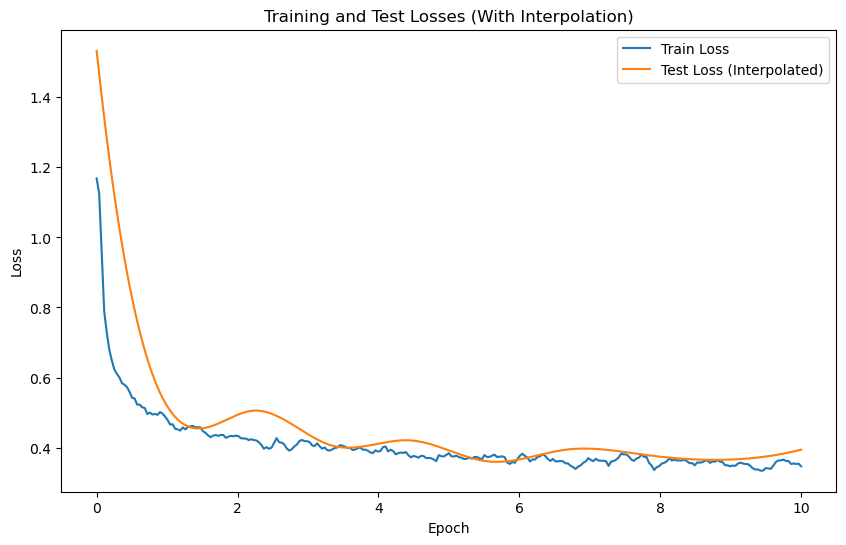

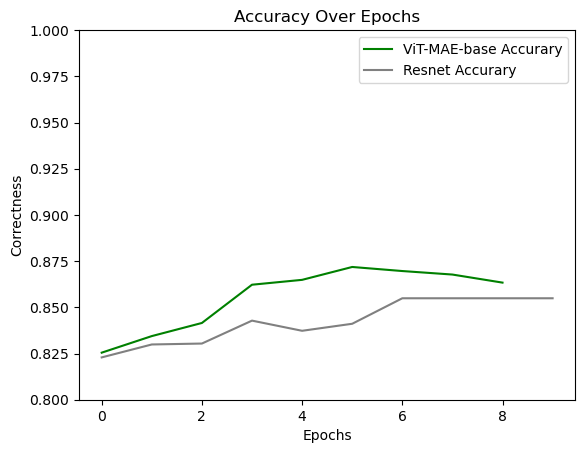

In [51]:
from scipy.interpolate import interp1d
from scipy.ndimage import uniform_filter1d

train_losses = np.load('train_losses.npy')
test_losses = np.load('test_losses.npy')
test_acc = np.load('test_correctness.npy')

window_size = 5
train_losses_smoothed = uniform_filter1d(train_losses, size=window_size, mode='reflect')
test_losses = np.insert(test_losses, 0, train_losses[0])
len_train_losses = len(train_losses)
len_test_losses = len(test_losses)
# Interpolating the test losses
x_rescaled = np.linspace(0, 10, num=len_train_losses)
x_test = np.linspace(0, len_train_losses-1, num=len_test_losses) # Original x-axis for test losses
f = interp1d(x_test, test_losses, kind='cubic')
x_new = np.arange(0, len_train_losses) # New x-axis for interpolated test losses
test_losses_interp = f(x_new)

# Plotting the interpolated test losses with the train losses
plt.figure(figsize=(10, 6))
plt.plot(x_rescaled, train_losses_smoothed, label='Train Loss')
plt.plot(x_rescaled, test_losses_interp, label='Test Loss (Interpolated)')
plt.title('Training and Test Losses (With Interpolation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.xlim(0, 10)
plt.legend()
plt.show()

# # Plotting the accuracy
# plt.figure(figsize=(10, 6))
# test_acc = np.insert(test_acc, 0, 0.75)
# f_acc = interp1d(x_test, test_acc, kind='cubic')
# test_acc_interp = f_acc(x_new)


# print(len(x_rescaled), len(test_acc_interp))
window_size = 3  
test_correctness_smoothed = uniform_filter1d(test_acc, size=window_size, mode='nearest')
# print(test_correctness_smoothed)
plt.plot(test_correctness_smoothed, label='ViT-MAE-base Accurary', color='green')
plt.plot(np.array([0.8229, 0.8299, 0.8304, 0.8428, 0.8373, 0.8411, 0.8549, 0.8549,
       0.8549, 0.8549]), label='Resnet Accurary', color='gray')
# Adding title and labels
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Correctness')
plt.ylim(0.8, 1)

# Adding legend
plt.legend()

# Show the plot
plt.show()


